In [1]:
from collections import defaultdict

import numpy as np
import torch as th

import matplotlib as mpl
import matplotlib.pyplot as plt

from mdps import MDP, Sim
from mdps.blueprints import FOUR_ROOMS, TWO_ROOMS

In [2]:
np.set_printoptions(precision=3, linewidth=128, suppress=True)
# plt.rcParams['figure.figsize'] = [5.0, 5.0]
# plt.rcParams['figure.dpi'] = 70

# Markov decision processes. Q-iteration and Policy-iteration.

## Lab policy

- This lab is a mandatory part of the "Control through Learning" course.
The solution is graded from 0 to 10.
The average of the `Python` labs counts for 30% of the final grade.

- The lab is preferably solved in groups of two students (larger groups are not allowed).
  A group submits a single solution, shared between the two students.

- The solution consists of:
    1. a short report written in English
    2. a copy of this notebook, containing your solutions
These two deliverables will be sent by email to lucian.busoniu@aut.utcluj.ro.

- The report will be in PDF format.
**It is mandatory to include complete listings of the Python code developed in the report** (only the code developed by you, not the shared code provided by the professor at the beginning of the lab).
The first page of the report will include the names of the students in the group.
Clearly explain the division of work between the two students in the report.

- The deadline for submitting the solution is **DDDD, 2024, by 24:00**.
Late submission is accepted, but the maximum grade is reduced by half: 5 points.
The time required to complete the lab depends on experience with `Python` programming, but part of the work will need to be done at home.
It is strongly recommended that you do not wait until right before the deadline to finish the solution.

- Discussion of ideas between groups is encouraged, but reusing code or reports (even partially) is not allowed. **Violation of this rule (copying) will result in immediate loss of the right to take the exam**.

- A discussion session will be organized where the contribution of each student will be determined through detailed technical questions, including questions related to `Python` implementation.

## Part 1


The objective of the first part is to become familiar with the interface provided by the Python implementation of the considered problem, as well as to review the basic concepts in Markov decision processes.
See the presentation of the first course, which can be downloaded at the above address.

### Environments

The final aim of the lab is to solve problems in the environment depicted in the figure, called `GRIDNAV`:

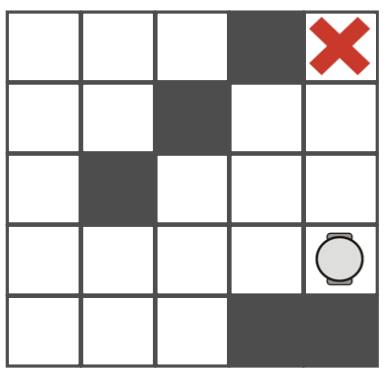

It is a simplification of a real robotic navigation problem.
In this problem, a robot must find the shortest path to a target (red X), avoiding obstacles (gray squares).
The robot's position varies on a $5 \times 5$ grid, with the state $x \in \{0, ..., 19\}$ (all states, excluding the 5 walls).
Note that the state $x=0$ represents the top-left corner in the figure.
The robot can move one cell at a time in one of the four cardinal directions.
These four actions $u$ are represented by the numbers 0 (up), 1 (right), 2 (down), 3 (left).
Any movement that results in hitting a wall or obstacle fails, and the robot remains in the same cell.
The robot receives a reward of $-0.1$ at each step in which it does not reach the target, and $10$ when it reaches the target.
The target is a terminal state, so when it is reached, the episode ends, and the robot is reset to an initial position.
The negative reward represents energy consumption and leads to a minimum-time solution, i.e., a path of minimal length.

For illustration purposes and for testing your implementation we will also use the `ROOMBA` MDP, which is described in the lecture slides.


- **TODO**: Create a navigation problem by choosing obstacle positions to make the problem interesting.
Simulate a trajectory by generating actions as you wish, for example, randomly (**2pts**). 

### Task 1.1
---

Familiarize yourself with the code and the interfaces you will be required to use in order to solve the rest of the assignment.

There are two main objects in this "library":

- an `MDP` which follows the Markov Decision Process formalism and encapsulates objects such as the set of states $S$, the transition dynamics $P$, and the reward function.
- an `Sim`, which takes an `MDP` as argument and makes out of it a _simulator_ exposing methods that make possible the agent-environment interaction loop (more on this later).

First, let's focus on the `MDP` class. It allows for easy definition of MDPs from a very simple domain specific language we call a `Blueprint`.

For keeping things simple, remember the cleaning robot from our lectures:

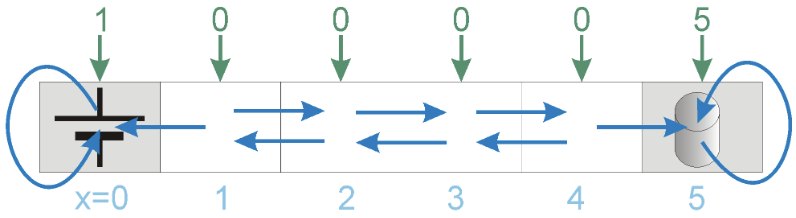

We can define this MDP using a few conventions:
- ` ` (space) is a special token, it indicates a state in which you can move in.
- `x` is a special token, it indicates an wall.
- `s` is a special token, it indicates the starting state.
- uppercase letters such as `T` (trash), `B` (battery) or `G` (goal) are terminal or absorbing states which end the episode.
- lowercase letters other that the special tokens above indicate rewarding states.
- everything above `---` is used to define rewards as field-value pairs:
    - `x: -0.1` negative reward when bumping into walls. 
    - `.: 0.0` reward associated with moving. Usually negative.
    - `T: 5.0` reward of 5 for picking up the trash (and restarting the episode)
    - `B: 1.0` reward of 1 for charging the battery (and restarting the episode)

Here's how you define the Cleaning Robot MDP using this DSL:

In [3]:
ROOMBA = """
B: 1.0
T: 5.0
x: 0.0
.: 0.0
---
xxxxxxxx
xBs   Tx
xxxxxxxx
"""

In [4]:
mdp = MDP(ROOMBA)
mdp

xxxxxxxx
xBs   Tx
xxxxxxxx
Actions: 0: right, 1: left

#### MDP interface

- `mpd.X` return the list of reachable states $X$
- `mdp.nX` return the number of states
- `mdp.nU` return the number of actions

**For solving the tasks you are only required to know about:**
- `mdp.f(x: int, u: int) -> x': int` returns the next state `x'` when applying action `u` while in state `x`.
- `mdp.rho(x: int, u: int) -> r: float` returns the reward `r` when applying action `u` while in state `x`.
- `mdp.ρ(x: int, u: int) -> r: float` is a shorthand (alias) of `mdp.rho`

In [5]:
# get the action-state dimensionality
print(f"#states:  {mdp.nX}")
print(f"#actions: {mdp.nU}")
print(f"states:   {mdp.X}")

#states:  6
#actions: 2
states:   [0, 1, 2, 3, 4, 5]


In [6]:
for x, u in ((4, 0), (3, 1)):
    print(f"Cleaner is in state x={x} and it applies action u={u}. Arrives in next state x={mdp.f(x, u)} with reward r={mdp.rho(x, u)}")

Cleaner is in state x=4 and it applies action u=0. Arrives in next state x=5 with reward r=5.0
Cleaner is in state x=3 and it applies action u=1. Arrives in next state x=2 with reward r=0.0


### Task 1.2 [2pts]
---

**For the `GRIDNAV` MDP described above**, identify the state variables and the state space, the action variables and the action space.
Write the transition function and the reward function using mathematical formulas in the very next cell, using $\LaTeX$.

**Solution**:

$x = \sqrt{42}$

(double click to edit this cell, `Shift+Enter` to execute it)

### Task 1.3 [1pts]
---

An `MDP` object can be used by the `Sim` object to create an environment with a simple API that facilitates the agent-environment interaction loop:

- `x, done = sim.reset()` returns the initial state and the episode termination signal. Use it to begin a new episode. `done` indicates the agent reached the goal.
- `x', r, done = sim.step(u)` receives action `u` and returns the next state, reward and episode termination signal.

**You have to**:
- Define an interesting navigation problem choosing the position of obstacles (walls), rewards and initial state.
- Simulate a trajectory with a policy of your choosing (pick actions manually or randomly).
- Record the number of time-steps required for the agent to reach the goal and print it.

In [7]:
mdp = MDP(ROOMBA) 
sim = Sim(mdp)

print(sim.reset())
print(sim.step(0))
print(sim.step(1))

(np.int64(1), False)
(2, 0.0, False)
(1, 0.0, False)


In [ ]:
# your solution here:

MYSIM = """

"""

mdp = MDP(MYSYM) 
sim = Sim(mdp)

s, done = sim.reset()
while not done:
    s, r, done = sim.step(1)
    print(s, r, done)

##  Part 2

In the second part of the lab we will implement and evaluate:

1. Q-iteration
2. Policy Iteration

You are encouraged to test your implementation on the `ROOMBA` MDP (because it's easier to understand), and then on the `GRIDNAV` mdp.

**Important:**
1. For both algorithms, you have to demonstrate your implementations are correct, by running them on the `GRIDNAV` environment, with a $\gamma=0.95$.
2. Visualize the resulting Q-values using `MDP.plot_values`. You can make separate plots for each action or you can plot $Q^*$. Visualise the resuling control law using `MDP.plot_policy`.



### Task 2.1 [3pts]
---

#### Q-iteration (value iteration with Q-values)

The algorithm has been presented in [lecture 2](https://busoniu.net/teaching/rl2024/slides_dp_handout.pdf).
The signature of the function is given below.
It receives:

- the `MDP` object
- the value of `γ`
- and a default value of `1e-4` for `ε_iter`

**Important:** test your implementation using the `ROOMBA` mdp.
The results should match closely the observations presented during the lecture.

In [9]:
def q_iteration(mdp, γ, ε_iter=1e-4):

    # TODO: your implementation here

    Qs = [th.zeros(mdp.nXU)]
    while True:
        Q = Qs[len(Qs) - 1].clone()
        for x in mdp.X:
            for u in mdp.U:
                Q[x, u] = mdp.ρ(x, u) + γ * Q[mdp.f(x, u)].max()
        Qs.append(Q)
        if (Qs[-2] - Q).abs().max() <= ε_iter:
            break
    #print(f"Finished in {len(Qs)} iterations.")
    return Qs[-1]

tensor([0.0000, 0.6250, 1.2500, 2.5000, 5.0000, 0.0000]) [0 1 2 3 4 5]
tensor([0.0000, 1.0000, 0.5000, 0.6250, 1.2500, 0.0000]) [0 1 2 3 4 5]


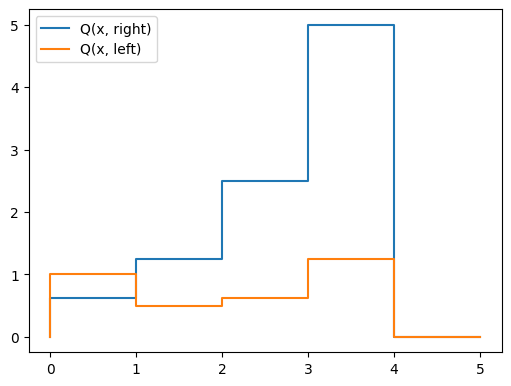

In [10]:
# check your implementation on the ROOMBA MDP.
# It should reproduce the values from the lecture exactly.

mdp = MDP(ROOMBA)
Q = q_iteration(mdp, γ=0.5)
mdp.qsa_lineplot(Q)

(<Figure size 640x480 with 2 Axes>, <Axes: >)

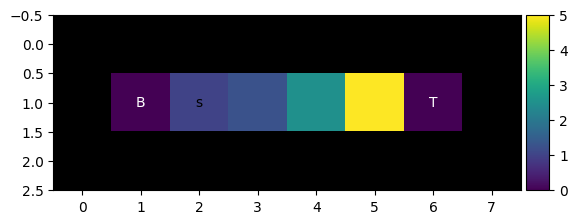

In [11]:
MDP.plot_values(mdp, Q.max(1).values)

If your implementation is working properly, you can now evaluate it on the larger MDP.

In [12]:
GRIDNAV = """
G: 10.0
x: -0.1
.: -0.1
---
xxxxxxx
x   xGx
x  x  x
x x   x
x     x
xs  xxx
xxxxxxx
"""

In [13]:
mdp = MDP(GRIDNAV)
mdp

xxxxxxx
x   xGx
x  x  x
x x   x
x     x
xs  xxx
xxxxxxx
Actions: 0: up, 1: right, 2: down, 3: left

(<Figure size 640x480 with 2 Axes>, <Axes: >)

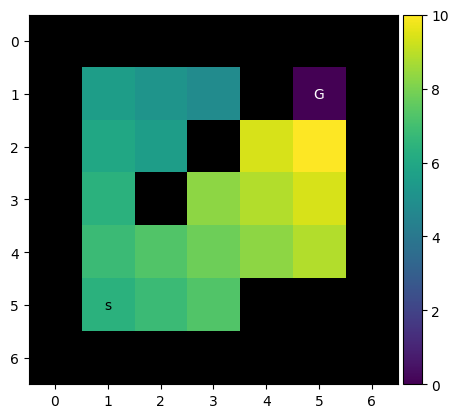

In [14]:
Q = q_iteration(mdp, γ=0.95)
MDP.plot_values(mdp, values=Q.max(1).values)

#### Policy Iteration

The algorithm has been presented in [lecture 2](https://busoniu.net/teaching/rl2024/slides_dp_handout.pdf).
The signature of the function is given below.
It receives:

- the `MDP` object
- the value of `γ`
- a default value of `1e-4` for `ε_eval`
- a default value of `100` for `max_iterations`, the maximum number of policy iterations if the stoping criteria has not been met.

In [15]:
def policy_iteration(mdp, γ, ε_eval=1e-4, max_iterations=100):
    
    # TODO: your implementation here
    
    h = th.stack([th.eye(mdp.nU)[i] for i in th.randint(0, 4, (mdp.nX,))]).long()
    for _ in range(max_iterations):
        Q = policy_evaluation(mdp, h, γ, ε_eval)
        h_ = th.zeros((mdp.nX, mdp.nU)).scatter(1, Q.argmax(1).unsqueeze(1), 1).long()
        if (h == h_).all():
            break
        h = h_
    return Q, h

def policy_evaluation(mdp, h, γ, ε_eval):
    Qs = [th.zeros((mdp.nX, mdp.nU))]
    while True:
        Q = Qs[len(Qs) - 1].clone()
        for x in mdp.X:
            for u in mdp.U:
                x_ = mdp.f(x, u)
                Q[x, u] = mdp.ρ(x, u) + γ * Q[x_, h[x_].argmax().item()]
        Qs.append(Q)
        if (Qs[-2] - Q).abs().max() <= ε_eval:
            break
    # print(f"Finished in {len(Qs)} iterations.")
    return Qs[-1]

In [16]:
Q, h = policy_iteration(mdp, 0.95)

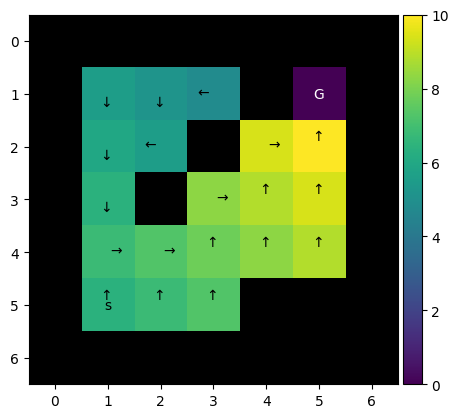

In [17]:
MDP.plot_policy(mdp, h, Q.max(1).values)

##  Part 3

In this third and last part of the lab we will look into the behaviour of the two algorithms you implemented and the resulting solutions they produce.

### Task 3.1 [1.5pts]
---

Compare i) the number of iterations and ii) the execution time of Q-iteration with those of Policy Iteration.

For Policy Iteration, consider on the one hand the number of (major) policy iterations $l$ and the number of (minor) policy evaluation iterations $\tau$.

You can use the `%timeit your_algo(...)` command for measuring the execution time of each algorithm.

In [18]:
%timeit q_iteration(mdp, γ=0.95)

8.78 ms ± 61.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit policy_iteration(mdp, 0.95)

1.22 s ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Your results:**

(edit this cell to describe your results)

### Task 3.2 [1.5pts]
---

Change, incrementally, the value of $\gamma$ from 0.6 to 0.99.
Execute one of the algorithms for obtaining $Q^*$ and $h^*$ for the values of $\gamma$ you experimented with.

Discuss the significance of $\gamma$ and the evolution of $Q^*$ with the value of $\gamma$.
How does the optimal control law change (why?/why not?).

**Your results:**

(edit this cell to describe your results)